In [7]:
# https://cloud.google.com/solutions/machine-learning/clv-prediction-with-offline-training-train?hl=ja
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.feature_column as fc

import os
import sys
from datetime import datetime as dt

import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd
import numpy as np

In [2]:
tf.enable_eager_execution()

In [3]:
# ファイル読み込み
os.chdir('../datasets')

FILE = 'OnlineRetail.xlsx'
raw_df = pd.read_excel(
    FILE,
    index_col=0)
raw_df

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceNo,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# InvoiceDateから日付のみの列を作成
print(raw_df.dtypes)
raw_df['order_date'] = raw_df.InvoiceDate.dt.date
raw_df

StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date
InvoiceNo,,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...
581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09
581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09
581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09


In [5]:
# 合計金額列を作成
raw_df['order_value'] = raw_df.Quantity * raw_df.UnitPrice
raw_df

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_value
InvoiceNo,,,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...
581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,10.20
581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,12.60
581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60


In [8]:
# train用とtest用に分割
train_df = raw_df[raw_df.order_date < dt(2011,6,1).date()]
test_df = raw_df[raw_df.order_date >= dt(2011,6,1).date()]

# 検証 -> OK
print(raw_df.count().head(1))
print(train_df.count().head(1))
print(test_df.count().head(1))

print(min(train_df.order_date), max(train_df.order_date))
print(min(test_df.order_date), max(test_df.order_date))

StockCode    541909
dtype: int64
StockCode    209029
dtype: int64
StockCode    332880
dtype: int64
2010-12-01 2011-05-31
2011-06-01 2011-12-09


In [10]:
# monetary算出（顧客あたりのすべての注文の合計金額。確率モデルでは、最初の注文の値が0であると想定）
mny = train_df.groupby('CustomerID')['order_value'].sum().to_frame().reset_index().rename(columns={'order_value': 'monetary'})
mny

,CustomerID,monetary
0,12346.0,0.00
1,12347.0,1823.43
2,12348.0,1487.24
3,12350.0,334.40
4,12352.0,601.18
...,...,...
2762,18273.0,51.00
2763,18277.0,-12.75
2764,18280.0,180.60
2765,18283.0,535.05


In [11]:
# frequency算出（機能の期間中に顧客が注文した数（日付ごとにまとめる）から最初の注文数を差し引いた数）

freq = train_df.groupby(['CustomerID', 'order_date'])['order_value'].count().reset_index().groupby(['CustomerID'])['order_value'].count().to_frame().reset_index()
freq['frequency'] = freq['order_value'] - 1
display(freq)

# 検証 -> OK
num = 12348
display(train_df[train_df.CustomerID == num].groupby('order_date')['order_date'].count().to_frame())
display(freq[freq.CustomerID == num])

,CustomerID,order_value,frequency
0,12346.0,1,0
1,12347.0,3,2
2,12348.0,3,2
3,12350.0,1,0
4,12352.0,4,3
...,...,...,...
2762,18273.0,1,0
2763,18277.0,1,0
2764,18280.0,1,0
2765,18283.0,5,4


,order_date
order_date,
2010-12-16,17
2011-01-25,6
2011-04-05,5


,CustomerID,order_value,frequency
2,12348.0,3,2


In [12]:
# t算出（顧客による最初の注文から機能の期間の終了までの時間）
## Threadhold dateをいつに設定するか -> 2011/06/01くらいかな
print(max(train_df.order_date))
print(min(train_df.order_date))
threadhold_date  = dt(2011, 6, 1, 0, 0, 0).date()
print(threadhold_date)
print(type(threadhold_date))

## 算出
time = train_df.groupby(['CustomerID', 'order_date'])['order_value'].count().to_frame().rename(columns={'order_value': 'count'}).reset_index()
time_max = time.groupby('CustomerID')['order_date'].max().to_frame().rename(columns={'order_date': 'order_date_max'})
time_min = time.groupby('CustomerID')['order_date'].min().to_frame().rename(columns={'order_date': 'order_date_min'})
time_merged = pd.merge(time_max, time_min, on='CustomerID', how='inner').reset_index()
time_merged['order_date_tmp_T'] = threadhold_date - time_merged['order_date_min']
time_merged['order_date_tmp_recency'] = threadhold_date - time_merged['order_date_max']

## timedeltaをintに変換
time_merged['T'] = (time_merged['order_date_tmp_T'] / np.timedelta64(1, 'D')).astype(int)
time_merged['recency'] = (time_merged['order_date_tmp_recency'] / np.timedelta64(1, 'D')).astype(int)
display(time_merged)
print(time_merged.dtypes)
del time_merged['order_date_tmp_T']
del time_merged['order_date_tmp_recency']

display(time_merged)

# 検証 -> OK
print(len(time_max))
print(len(time_min))
print(len(time_merged))

num = 12348
display(time[time.CustomerID == num])
display(time_merged[time_merged.CustomerID == num])

2011-05-31
2010-12-01
2011-06-01
<class 'datetime.date'>


,CustomerID,order_date_max,order_date_min,order_date_tmp_T,order_date_tmp_recency,T,recency
0,12346.0,2011-01-18,2011-01-18,134 days,134 days,134,134
1,12347.0,2011-04-07,2010-12-07,176 days,55 days,176,55
2,12348.0,2011-04-05,2010-12-16,167 days,57 days,167,57
3,12350.0,2011-02-02,2011-02-02,119 days,119 days,119,119
4,12352.0,2011-03-22,2011-02-16,105 days,71 days,105,71
...,...,...,...,...,...,...,...
2762,18273.0,2011-03-27,2011-03-27,66 days,66 days,66,66
2763,18277.0,2011-01-25,2011-01-25,127 days,127 days,127,127
2764,18280.0,2011-03-07,2011-03-07,86 days,86 days,86,86
2765,18283.0,2011-05-23,2011-01-06,146 days,9 days,146,9


CustomerID                        float64
order_date_max                     object
order_date_min                     object
order_date_tmp_T          timedelta64[ns]
order_date_tmp_recency    timedelta64[ns]
T                                   int64
recency                             int64
dtype: object


,CustomerID,order_date_max,order_date_min,T,recency
0,12346.0,2011-01-18,2011-01-18,134,134
1,12347.0,2011-04-07,2010-12-07,176,55
2,12348.0,2011-04-05,2010-12-16,167,57
3,12350.0,2011-02-02,2011-02-02,119,119
4,12352.0,2011-03-22,2011-02-16,105,71
...,...,...,...,...,...
2762,18273.0,2011-03-27,2011-03-27,66,66
2763,18277.0,2011-01-25,2011-01-25,127,127
2764,18280.0,2011-03-07,2011-03-07,86,86
2765,18283.0,2011-05-23,2011-01-06,146,9


2767
2767
2767


,CustomerID,order_date,count
4,12348.0,2010-12-16,17
5,12348.0,2011-01-25,6
6,12348.0,2011-04-05,5


,CustomerID,order_date_max,order_date_min,T,recency
2,12348.0,2011-04-05,2010-12-16,167,57


In [13]:
# マージDF確認
display(freq)
display(mny)
display(time_merged)

,CustomerID,order_value,frequency
0,12346.0,1,0
1,12347.0,3,2
2,12348.0,3,2
3,12350.0,1,0
4,12352.0,4,3
...,...,...,...
2762,18273.0,1,0
2763,18277.0,1,0
2764,18280.0,1,0
2765,18283.0,5,4


,CustomerID,monetary
0,12346.0,0.00
1,12347.0,1823.43
2,12348.0,1487.24
3,12350.0,334.40
4,12352.0,601.18
...,...,...
2762,18273.0,51.00
2763,18277.0,-12.75
2764,18280.0,180.60
2765,18283.0,535.05


,CustomerID,order_date_max,order_date_min,T,recency
0,12346.0,2011-01-18,2011-01-18,134,134
1,12347.0,2011-04-07,2010-12-07,176,55
2,12348.0,2011-04-05,2010-12-16,167,57
3,12350.0,2011-02-02,2011-02-02,119,119
4,12352.0,2011-03-22,2011-02-16,105,71
...,...,...,...,...,...
2762,18273.0,2011-03-27,2011-03-27,66,66
2763,18277.0,2011-01-25,2011-01-25,127,127
2764,18280.0,2011-03-07,2011-03-07,86,86
2765,18283.0,2011-05-23,2011-01-06,146,9


In [14]:
# マージ
merged = pd.merge(freq.loc[:, ['CustomerID', 'frequency']], mny.loc[:, ['CustomerID', 'monetary']], on='CustomerID', how='inner')
merged = pd.merge(merged, time_merged.loc[:, ['CustomerID', 'T', 'recency']], on='CustomerID', how='inner')
merged

,CustomerID,frequency,monetary,T,recency
0,12346.0,0,0.00,134,134
1,12347.0,2,1823.43,176,55
2,12348.0,2,1487.24,167,57
3,12350.0,0,334.40,119,119
4,12352.0,3,601.18,105,71
...,...,...,...,...,...
2762,18273.0,0,51.00,66,66
2763,18277.0,0,-12.75,127,127
2764,18280.0,0,180.60,86,86
2765,18283.0,4,535.05,146,9


In [15]:
# frequencyが0の行は排除-> 2767から1534に減った
merged = merged[merged.frequency != 0]
merged

,CustomerID,frequency,monetary,T,recency
1,12347.0,2,1823.43,176,55
2,12348.0,2,1487.24,167,57
4,12352.0,3,601.18,105,71
8,12356.0,1,2753.08,134,54
9,12359.0,2,2350.61,140,49
...,...,...,...,...,...
2757,18260.0,6,2167.87,167,9
2759,18269.0,1,138.90,175,167
2760,18270.0,1,67.75,75,49
2761,18272.0,2,966.74,55,21


In [16]:
# monetaryが0かマイナスな行は排除 -> 1534から1525に減った
merged = merged[merged.monetary > 0]
merged

,CustomerID,frequency,monetary,T,recency
1,12347.0,2,1823.43,176,55
2,12348.0,2,1487.24,167,57
4,12352.0,3,601.18,105,71
8,12356.0,1,2753.08,134,54
9,12359.0,2,2350.61,140,49
...,...,...,...,...,...
2757,18260.0,6,2167.87,167,9
2759,18269.0,1,138.90,175,167
2760,18270.0,1,67.75,75,49
2761,18272.0,2,966.74,55,21


In [17]:
# 並び替え
merged = merged.loc[:, ['CustomerID', 'frequency', 'recency', 'T', 'monetary']]
merged

,CustomerID,frequency,recency,T,monetary
1,12347.0,2,55,176,1823.43
2,12348.0,2,57,167,1487.24
4,12352.0,3,71,105,601.18
8,12356.0,1,54,134,2753.08
9,12359.0,2,49,140,2350.61
...,...,...,...,...,...
2757,18260.0,6,9,167,2167.87
2759,18269.0,1,167,175,138.90
2760,18270.0,1,49,75,67.75
2761,18272.0,2,21,55,966.74


In [18]:
# Gamma-Gammaモデルは金銭的価値と購入頻度に相関がないことを仮定しているため、それを確認する必要がある -> 微妙なところ。。
merged[['monetary', 'frequency']].corr()

,monetary,frequency
monetary,1.000000,0.490381
frequency,0.490381,1.000000


In [19]:
## GammaGammaFitter ##
# Fitting
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(merged['frequency'], merged['monetary'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1525 subjects, p: 1.67, q: 2.04, v: 1123.13>


In [20]:
result = ggf.conditional_expected_average_profit(merged['frequency'], merged['monetary']).to_frame().reset_index().rename(columns={'index': 'CustomerID', 0: 'LTV_ggf'})
display(result)

pd.merge(merged, result, on='CustomerID', left_index=True,right_index=True)

,CustomerID,LTV_ggf
0,1,1819.246487
1,2,1562.804416
2,4,808.034365
3,8,2389.832932
4,9,2221.373652
...,...,...
1520,2757,2133.862568
1521,2759,778.088270
1522,2760,734.221500
1523,2761,1165.772682


,CustomerID,frequency,recency,T,monetary,LTV_ggf
1,12347.0,2,55,176,1823.43,1562.804416
2,12348.0,2,57,167,1487.24,808.034365
4,12352.0,3,71,105,601.18,2221.373652
8,12356.0,1,54,134,2753.08,1696.250900
9,12359.0,2,49,140,2350.61,1748.732418
...,...,...,...,...,...,...
1515,15570.0,7,15,178,2469.87,1594.468747
1516,15572.0,1,57,87,876.04,1120.378549
1517,15574.0,1,167,181,590.15,1342.781238
1520,15581.0,6,35,175,634.96,2133.862568


In [21]:
## BetaGeoFitter ##
# Fitting
from lifetimes import BetaGeoFitter

display(merged)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(merged['frequency'], merged['recency'], merged['T'])
print(bgf)

,CustomerID,frequency,recency,T,monetary
1,12347.0,2,55,176,1823.43
2,12348.0,2,57,167,1487.24
4,12352.0,3,71,105,601.18
8,12356.0,1,54,134,2753.08
9,12359.0,2,49,140,2350.61
...,...,...,...,...,...
2757,18260.0,6,9,167,2167.87
2759,18269.0,1,167,175,138.90
2760,18270.0,1,49,75,67.75
2761,18272.0,2,21,55,966.74


<lifetimes.BetaGeoFitter: fitted with 1525 subjects, a: 2.01, alpha: 1.24, b: 4.47, r: 0.42>


In [22]:
# 推定されたパラメータ
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.415353,0.013954,0.388003,0.442703
alpha,1.244284,0.077300,1.092776,1.395792
a,2.008979,0.122860,1.768173,2.249785
b,4.473699,0.310725,3.864678,5.082721


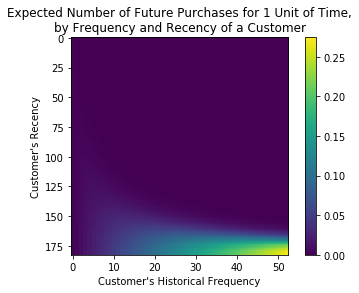

In [23]:
# Frequency/Recency Matrix
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

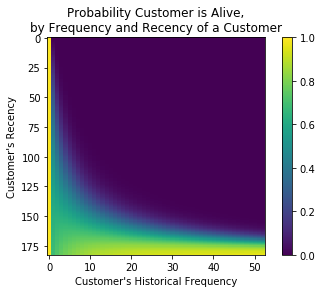

In [24]:
# 生存確率
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

In [25]:
# predeicted_purchases
# https://github.com/CamDavidsonPilon/lifetimes/blob/71d97ba52e1d730cda70b771038a3dc4c42f310a/lifetimes/fitters/beta_geo_fitter.py#L199
t = 90 # 予想する日数
bgf_result = merged
bgf_result['transaction_bgf_tmp'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, bgf_result['frequency'], bgf_result['recency'], bgf_result['T'])
bgf_result['transaction_bgf'] = bgf_result['transaction_bgf_tmp'].round(5)
del bgf_result['transaction_bgf_tmp']
display(bgf_result.sort_values(by='transaction_bgf').head(5))
display(bgf_result.sort_values(by='transaction_bgf').tail(5))

,CustomerID,frequency,recency,T,monetary,transaction_bgf
1254,15005.0,11,6,175,2564.10,0.0
801,14060.0,9,14,181,2957.10,0.0
799,14057.0,6,8,169,2605.97,0.0
798,14056.0,9,6,93,3294.03,0.0
2398,17512.0,6,9,110,1297.47,0.0


,CustomerID,frequency,recency,T,monetary,transaction_bgf
2008,16642.0,1,15,16,299.23,2.03990
2101,16818.0,3,8,14,694.64,2.10878
1459,15434.0,1,8,9,262.96,2.46827
1059,14584.0,1,6,7,474.80,2.62060
2664,18073.0,1,5,6,241.08,2.70006


In [26]:
# 検証 -> 精度はあまり高くない（使っているデータの問題な気がする）
raw_df
check_df = raw_df[raw_df.order_date >= dt(2011,6,1).date()]
check_df = check_df[check_df.order_date < dt(2011,9,1).date()]
check_df

def check_bgf(num):
    print('確認対象ID: {}'.format(num))
    print('予想トランザクション: {}'.format(bgf_result[bgf_result.CustomerID == num]['transaction_bgf'].values))
    print('実際のトランザクション: {}'.format(check_df[check_df.CustomerID == num].groupby(['CustomerID', 'order_date'])['order_value'].count().reset_index().groupby(['CustomerID'])['order_value'].count().values))

print('--Top4--')
check_bgf(18073)
check_bgf(14584)
check_bgf(15434)
check_bgf(16818)

print('--Worst4--')
check_bgf(15005)
check_bgf(14060)
check_bgf(14057)
check_bgf(14056)

--Top4--
確認対象ID: 18073
予想トランザクション: [2.70006]
実際のトランザクション: [8]
確認対象ID: 14584
予想トランザクション: [2.6206]
実際のトランザクション: [3]
確認対象ID: 15434
予想トランザクション: [2.46827]
実際のトランザクション: [1]
確認対象ID: 16818
予想トランザクション: [2.10878]
実際のトランザクション: [6]
--Worst4--
確認対象ID: 15005
予想トランザクション: [0.]
実際のトランザクション: [7]
確認対象ID: 14060
予想トランザクション: [0.]
実際のトランザクション: [4]
確認対象ID: 14057
予想トランザクション: [0.]
実際のトランザクション: [5]
確認対象ID: 14056
予想トランザクション: [0.]
実際のトランザクション: [8]


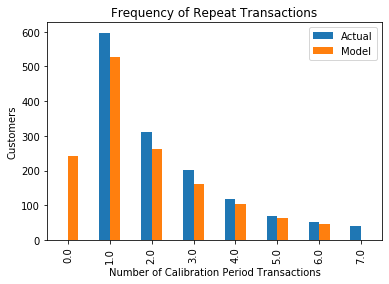

In [27]:
# モデル評価（ActualとModelが近ければ良い） -> あまり良くなさそう
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_value
InvoiceNo,,,,,,,,,
554844,23053,RECYCLED ACAPULCO MAT PINK,2,2011-05-26 19:38:00,8.25,18073.0,United Kingdom,2011-05-26,16.50
554844,23052,RECYCLED ACAPULCO MAT TURQUOISE,2,2011-05-26 19:38:00,8.25,18073.0,United Kingdom,2011-05-26,16.50
554844,84946,ANTIQUE SILVER T-LIGHT GLASS,24,2011-05-26 19:38:00,1.25,18073.0,United Kingdom,2011-05-26,30.00
554944,84946,ANTIQUE SILVER T-LIGHT GLASS,72,2011-05-27 14:12:00,1.06,18073.0,United Kingdom,2011-05-27,76.32
554944,22178,VICTORIAN GLASS HANGING T-LIGHT,96,2011-05-27 14:12:00,1.06,18073.0,United Kingdom,2011-05-27,101.76
...,...,...,...,...,...,...,...,...,...
563561,22697,GREEN REGENCY TEACUP AND SAUCER,12,2011-08-17 14:02:00,2.95,18073.0,United Kingdom,2011-08-17,35.40
563561,22178,VICTORIAN GLASS HANGING T-LIGHT,96,2011-08-17 14:02:00,1.06,18073.0,United Kingdom,2011-08-17,101.76
563561,22464,HANGING METAL HEART LANTERN,24,2011-08-17 14:02:00,1.65,18073.0,United Kingdom,2011-08-17,39.60


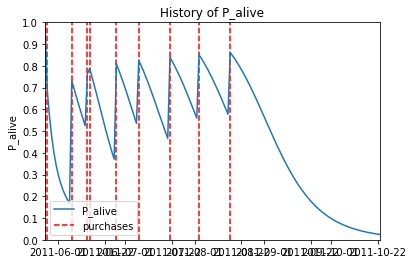

In [28]:
# 生存確率
from lifetimes.plotting import plot_history_alive

days_since_birth = 150
sp_trans = raw_df.loc[raw_df['CustomerID'] == 18073]
display(sp_trans)
plot_history_alive(bgf, days_since_birth, sp_trans, 'order_date')